In [2]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

import numpy as np
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens
from temgym_core.gaussian import make_gaussian_image, GaussianRay, evaluate_gaussian_input_image
from temgym_core.source import ParallelBeam
from temgym_core.ray import Ray
from temgym_core.utils import fibonacci_spiral, custom_jacobian_matrix
from temgym_core.run import run_to_end

%matplotlib widget
import matplotlib.pyplot as plt

In [10]:
aperture_window_width = 1e-6  # 1 um aperture window width
num_aper_pixels = 256
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 2.5e-7  # 500 nm aperture radius

num_beams = int(1e5)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12  # 2 pm wavelength
k = 2 * np.pi / wavelength
wo = 2e-9

#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [11]:

# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [12]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [13]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

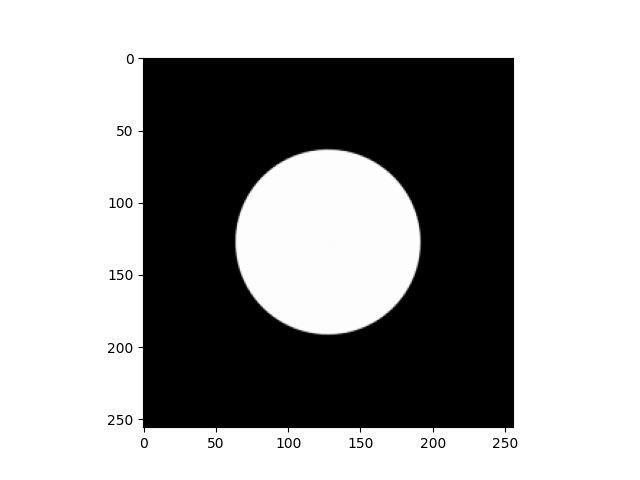

In [14]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray')

In [62]:
prop_d = 1e-6

input_beam = ParallelBeam(z=0.0, radius=aperture_radius)
detector = Detector(z=prop_d, shape=(num_aper_pixels, num_aper_pixels), pixel_size=aperture_pixel_size)
model = [
    detector,
]

central_ray = Ray(x=0.0, y=0.0, dx=0.0, dy=0.0, z=input_beam.z, pathlength=0.0, _one=1.0)
out_ray = run_to_end(central_ray, model)

ABCD = jax.jacobian(lambda r: run_to_end(r, model))(central_ray)
ABCD = custom_jacobian_matrix(ABCD)
print(ABCD)

A = ABCD[0:2, 0:2]
B = ABCD[0:2, 2:4]
C = ABCD[2:4, 0:2]
D = ABCD[2:4, 2:4]

[[1.e+00 0.e+00 1.e-06 0.e+00 0.e+00]
 [0.e+00 1.e+00 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+00]]


In [63]:
# from temgym_core.gaussian import matrix_matrix_mul, matrix_vector_mul, matrix_quadratic_mul, matrix_linear_mul, Qinv_ABCD
# vmap_fn = jax.vmap(jax.jacobian(run_to_end), in_axes=(0, None))
# central_rays = rays.to_ray()
# output_tm = vmap_fn(central_rays, model)

# model_ray_jacobians = custom_jacobian_matrix(output_tm)
# ABCDs = jnp.array(model_ray_jacobians)

# amp = rays.amplitude

# Q1_inv = rays.Q_inv[0]  # Should be of shape n x 2 x 2
# Q2_inv = Qinv_ABCD(A, B, C, D, Q1_inv)  # (nb,2,2)
# A = ABCDs[0, 0:2, 0:2]  # (nb,2,2)
# B = ABCDs[0, 0:2, 2:4]  # (nb,2,2)
# C = ABCDs[0, 2:4, 0:2]  # (nb,2,2)
# D = ABCDs[0, 2:4, 2:4]  # (nb,2,2)
# e = ABCDs[0, 0:2, 4]  # (nb,2)
# r2 = detector.coords
# r1m = jnp.stack([central_rays.x, central_rays.y], axis=-1)[0]
# theta1m = jnp.stack([central_rays.dx, central_rays.dy], axis=-1)[0]
# wavelengths = rays.wavelength
# k = 2 * jnp.pi / wavelengths

# print(Q2_inv)

In [64]:
# I = jnp.eye(2)
# B_inv = jnp.linalg.solve(B, I)
# B_inv = jnp.nan_to_num(B_inv, nan=0.0, posinf=0.0, neginf=0.0)

# Q1 = jnp.linalg.solve(Q1_inv, I)
# Q1 = jnp.nan_to_num(Q1, nan=0.0, posinf=0.0, neginf=0.0)

# # Central ray at output: r2m = A r1m + B theta1m + e
# r2m = matrix_vector_mul(A, r1m) + matrix_vector_mul(B, theta1m) + e  # (2,)

# # AB-q amplitude prefactor
# denom = A + matrix_matrix_mul(B, Q1_inv)  # (2,2)
# pref = amp / jnp.sqrt(jnp.linalg.det(denom))  # ()

# # Misalignment phase (input plane)
# ABinv = matrix_matrix_mul(A, B_inv)
# phi1 = matrix_quadratic_mul(r1m, ABinv) - 2 * matrix_linear_mul(
#     r1m, B_inv, r2
# )  # (np,)

# # Misalignment phase (output plane)
# AQ1 = matrix_matrix_mul(A, Q1)
# B_over_AQ1B = jnp.linalg.solve(matrix_matrix_mul(B, AQ1 + B), I)  # (2,2)
# Q1B_over_AQ = matrix_matrix_mul(Q1, B_over_AQ1B)  # (2,2)
# phi2 = matrix_quadratic_mul(r2m, Q1B_over_AQ) - 2 * matrix_linear_mul(
#     r2m, Q1B_over_AQ, r2
# )  # (np,)

# Q2t = jnp.einsum("ni,ij,nj->n", r2, Q2_inv, r2)  # (np,)

# phase = (k / 2) * (Q2t + phi1 - phi2)  # (np,)

# out = pref * jnp.exp(1j * phase)
# out = out.reshape(detector.shape)

In [65]:
# plt.figure()
# plt.imshow(jnp.abs(out), cmap='gray')

# plt.figure()
# plt.imshow(jnp.angle(out), cmap='gray')

In [66]:
rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=jnp.ones_like(xs) * input_beam.z,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,
    radii_of_curv=radii_of_curv,
    wavelength=wavelengths, 
    theta=theta,
)
det_image = make_gaussian_image(rays, model, batch_size=100)

In [67]:
central_rays = rays.to_ray()
out_rays = run_to_end(central_rays, model)

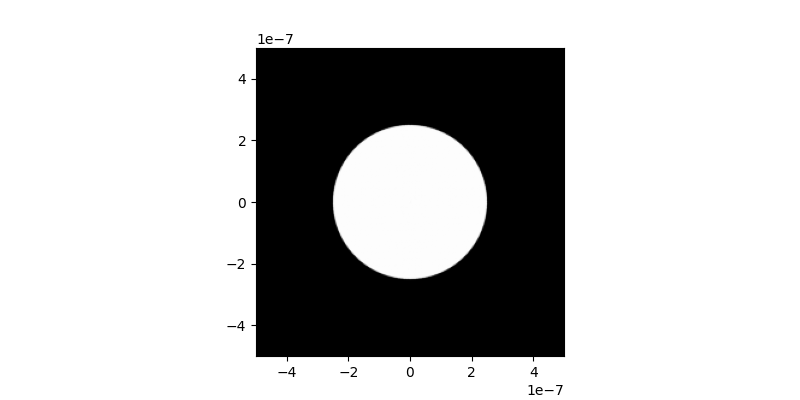

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
img = np.abs(det_image)
ang = np.angle(det_image)

ax.plot(out_rays.x, out_rays.y, 'g.', markersize=1, alpha=0.001)
ax.imshow(img, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])
#ax.imshow(ang, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])